In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from gurobi_optimods import opf
from gurobi_optimods.opf.structs import Branch, Bus, Gen
from gurobi_optimods.opf import converters
from tqdm import tqdm
from gurobi_optimods.opf.grbformulator import fill_result_fields
import logging
logger = logging.getLogger(__name__)
from enum import Enum
import time
import math
import random
import pickle
import os
import glob
import torch
import torch.linalg as la
# from numpy.random import default_rng
# rng = default_rng()
# case_path = './excel_outputs/pglib_opf_case300_ieee.xlsx'
# case_pd = pd.read_excel(case_path, sheet_name=['baseMVA', 'bus','gen','gencost','branch'])

In [2]:
user_params = {}

def create_env(params=None):
    final_params = {}
    final_params.update(decorator_params)
    if params:
        final_params.update(params)
    if user_params:
        final_params.update(user_params)
    return gp.Env(params=final_params)
def convert_case_to_internal_format(case_dict):
    # Input data validation
    if len(case_dict["gen"]) != len(case_dict["gencost"]):
        raise ValueError("Invalid input: mismatch between gen and gencost records")

    for gencost in case_dict["gencost"]:
        if gencost["costtype"] != 2:
            raise ValueError("Invalid input: only generator costtype=2 is supported")
        if gencost["n"] != len(gencost["costvector"]):
            raise ValueError(
                "Invalid input: mismatch between gencost.n and costvector length"
            )
        if gencost["n"] > 3:
            raise ValueError(
                "Invalid input: only quadratic and linear cost functions "
                "(gencost.n <= 3) are supported"
            )

    bus_ids = {bus["bus_i"] for bus in case_dict["bus"]}
    if any(branch["fbus"] not in bus_ids for branch in case_dict["branch"]):
        raise ValueError("Unknown bus ID referenced in branch fbus")
    if any(branch["tbus"] not in bus_ids for branch in case_dict["branch"]):
        raise ValueError("Unknown bus ID referenced in branch tbus")
    if any(gen["bus"] not in bus_ids for gen in case_dict["gen"]):
        raise ValueError("Unknown bus ID referenced in generator bus")

    # For each field we create a key value for use internally.
    # Note: index != nodeID (bus_i) for buses.
    # Note: some parts of the code still rely on these indexes being 1..n and
    # the keys being in ascending order in dictionary iterators. Be very careful
    # when trying to change this.
    # Remove isolated buses and their connected branches
    remove_buses = {bus["bus_i"] for bus in case_dict["bus"] if bus["type"] == 4}
    if remove_buses:
        logger.info(f"Removing buses {remove_buses} (bustype=4)")

    # For each field we create a key value for use internally.
    # Note: index != nodeID (bus_i) for buses.
    # Note: some parts of the code still rely on these indexes being 1..n and
    # the keys being in ascending order in dictionary iterators. Be very careful
    # when trying to change this.
    case_dict = {
        "baseMVA": case_dict["baseMVA"],
        "bus": {
            i + 1: dict(bus)
            for i, bus in enumerate(case_dict["bus"])
            if bus["bus_i"] not in remove_buses
        },
        "branch": {
            i + 1: dict(branch)
            for i, branch in enumerate(case_dict["branch"])
            if branch["fbus"] not in remove_buses and branch["tbus"] not in remove_buses
        },
        "gen": {i + 1: dict(gen) for i, gen in enumerate(case_dict["gen"])},
        "gencost": {
            i + 1: dict(gencost) for i, gencost in enumerate(case_dict["gencost"])
        },
        "casename": case_dict["casename"],
    }

    # Manual correction to ratios
    for branch in case_dict["branch"].values():
        if branch["ratio"] == 0.0:
            branch["ratio"] = 1.0

    alldata = {"LP": {}, "MIP": {}}
    alldata["casename"] = case_dict["casename"]
    logger.info("Building case data structures from dictionary.")
    baseMVA = alldata["baseMVA"] = case_dict["baseMVA"]
    # Buses
    logger.info("Buses.")
    buses = {}
    IDtoCountmap = {}
    slackbus = refbus = -1
    numbuses = 0
    numPload = 0
    sumPd = sumQd = 0
    numisolated = 0
    dict_buses = case_dict["bus"]

    for dbus in dict_buses.values():
        numbuses += 1
        count = numbuses
        nodeID = dbus["bus_i"]
        nodetype = dbus["type"]
        Pd = dbus["Pd"]
        Qd = dbus["Qd"]

        if nodetype not in [1, 2, 3, 4]:
            raise ValueError(
                f"Bus {count} has type {nodetype}. Only bus types [1,2,3,4] allowed."
            )

        if nodetype == 3:
            slackbus = refbus = count
            logger.info(f"    Bus {count} ID {nodeID} is the reference bus.")

        if nodetype == 4:
            numisolated += 1

        if nodetype in [1, 2, 3]:
            sumPd += Pd
            sumQd += Qd

        buses[numbuses] = Bus(
            numbuses,
            nodeID,
            nodetype,
            Pd / baseMVA,
            Qd / baseMVA,
            dbus["Gs"] / baseMVA,
            dbus["Bs"] / baseMVA,
            dbus["area"],
            dbus["Vm"],
            dbus["Va"],
            dbus["baseKV"],
            dbus["zone"],
            dbus["Vmax"],
            dbus["Vmin"],
        )

        # Could save a lot of pain by using the nodeID as the ... node ID :-)
        # assert nodeID == count
        IDtoCountmap[nodeID] = count
        numPload += Pd > 0

    alldata["buses"] = buses
    alldata["numbuses"] = numbuses
    alldata["sumPd"] = sumPd
    alldata["sumQd"] = sumQd
    alldata["IDtoCountmap"] = IDtoCountmap
    alldata["slackbus"] = slackbus
    alldata["refbus"] = refbus

    logger.info(f"    sumloadPd {sumPd} numPload {numPload}")
    logger.info(f"    sumloadQd {sumQd}")

    if slackbus < 0:
        logger.info("    Could not find slack bus.")

    logger.info(f"    {numbuses} buses")
    if numisolated > 0:
        logger.info(f"    Isolated buses: {numisolated}")

    # Branches
    logger.info("Branches.")
    branches = {}
    defaultlimit = 1e20
    numbranches = 0
    activebranches = 0
    dict_branches = case_dict["branch"]

    for dbranch in dict_branches.values():
        # print(dbranch)
        numbranches += 1
        brcnt1 = numbranches
        ratio = dbranch["ratio"]
        minangle = dbranch["angmin"]
        maxangle = dbranch["angmax"]
        f = dbranch["fbus"]
        t = dbranch["tbus"]
        count_f = IDtoCountmap[f]
        count_t = IDtoCountmap[t]

        # TODO why do we adjust this manually? Is this invalid input data?
        if ratio == 0:
            ratio = 1.0  # to be sure

        if maxangle < minangle:
            raise ValueError(
                f"Branch # {numbranches} has illegal angle constraints. "
                f"minangle: {minangle} > {maxangle} :maxangle"
            )

        branches[numbranches] = Branch(
            brcnt1,
            f,
            count_f,
            t,
            count_t,
            dbranch["r"],
            dbranch["x"],
            dbranch["b"],
            dbranch["rateA"] / baseMVA,
            dbranch["rateB"] / baseMVA,
            dbranch["rateC"] / baseMVA,
            ratio,
            dbranch["angle"],
            dbranch["status"],
            maxangle,
            minangle,
            defaultlimit,
        )
        activebranches += 1
        buses[count_f].addfrombranch(brcnt1)
        buses[count_t].addtobranch(brcnt1)

    alldata["branches"] = branches
    alldata["numbranches"] = numbranches
    logger.info(f"    Numbranches: {numbranches} active: {activebranches}")

    # Generators
    logger.info("Generators.")
    gens = {}
    summaxgenP = summaxgenQ = 0
    numgens = 0
    dict_gens = case_dict["gen"]

    for dgen in dict_gens.values():
        numgens += 1
        gencount1 = numgens
        nodeID = dgen["bus"]
        Qmax = dgen["Qmax"]
        Pmax = dgen["Pmax"]
        idgencount1 = IDtoCountmap[nodeID]

        if nodeID not in IDtoCountmap.keys():
            raise ValueError(f"Generator # {gencount1} in nonexistent bus ID {nodeID}.")

        if buses[idgencount1].nodetype in [2, 3]:  # But not 4
            summaxgenP += Pmax
            summaxgenQ += Qmax

        # From MATPOWER Generator Data Format
        # https://matpower.org/docs/ref/matpower5.0/caseformat.html
        #
        # 8   status,  >  0 - machine in service
        #             <= 0 - machine out of service
        dgen["status"] == 0 if dgen["status"] <= 0 else 1
        assert dgen["status"] in (0, 1)

        gens[gencount1] = Gen(
            gencount1,
            nodeID,
            dgen["Pg"],
            dgen["Qg"],
            Qmax / baseMVA,
            dgen["Qmin"] / baseMVA,
            dgen["Vg"],
            dgen["mBase"],
            dgen["status"],
            Pmax / baseMVA,
            dgen["Pmin"] / baseMVA,
            dgen["Pc1"],
            dgen["Pc2"],
            dgen["Qc1min"],
            dgen["Qc1max"],
            dgen["Qc2min"],
            dgen["Qc2max"],
            dgen["ramp_agc"],
            dgen["ramp_10"],
            dgen["ramp_30"],
            dgen["ramp_q"],
            dgen["apf"],
        )

        buses[idgencount1].addgenerator(gencount1, gens[gencount1])

    alldata["gens"] = gens
    alldata["numgens"] = len(gens)
    busgencount = 0

    for bus in buses.values():
        busgencount += len(bus.genidsbycount) > 0

    alldata["busgencount"] = busgencount
    alldata["summaxgenP"] = summaxgenP
    alldata["summaxgenQ"] = summaxgenQ

    logger.info(f"    Number of generators: {alldata['numgens']}")
    logger.info(f"    Number of buses with gens: {busgencount}")
    logger.info(f"    summaxPg {summaxgenP} summaxQg {summaxgenQ}")

    logger.info("Generator cost vectors.")
    gencoststruct = case_dict["gencost"]

    for count in range(1, alldata["numgens"] + 1):
        gens[count].addcost_plain(
            gencoststruct[count]["costvector"],
            gencoststruct[count]["costtype"],
            gencoststruct[count]["startup"],
            gencoststruct[count]["shutdown"],
            baseMVA,
        )

    return alldata

opftype = "dc"
useef = False
usejabr = False
default_solver_params = {"MIPGap": 1e-4, "OptimalityTol": 1e-4}
branch_switching=False
min_active_branches=0.9
use_mip_start=False
polar=False
ivtype="aggressive"
branchswitching=branch_switching
usemipstart=use_mip_start
minactivebranches=min_active_branches
useactivelossineqs=False
decorator_params = {"OutputFlag": 0}
env = create_env(params=default_solver_params)

settings = converters.build_internal_settings(
    opftype,
    polar,
    useef,
    usejabr,
    ivtype,
    branchswitching,
    usemipstart,
    minactivebranches,
    useactivelossineqs,
)

In [3]:
class OpfType(Enum):
    """
    Defines possible OPF formulation types
    """

    AC = "AC"
    DC = "DC"
    IV = "IV"
def construct_and_solve_model(env, alldata):
    """Construct OPF model for given data and solve it. Return the solution
    dictionary."""

    if alldata["doac"]:
        opftype = OpfType.AC
    elif alldata["dodc"]:
        opftype = OpfType.DC
    elif alldata["doiv"]:
        opftype = OpfType.IV
    else:
        # Should not happen (this would be a configuration setup bug)
        raise ValueError("No model type set")

    logger.info(f"Running {opftype.value}OPF formulation.")

    # Create model
    with gp.Model(f"{opftype.value}_Formulation_Model", env=env) as model:
        # Formulate model, update and print statistics

        tic = time.perf_counter()

        if opftype == OpfType.AC:
            lpformulator_ac_body(alldata, model)
        elif opftype == OpfType.DC:
            lpformulator_dc_body(alldata, model)
        elif opftype == OpfType.IV:
            lpformulator_iv_body(alldata, model)
        else:
            raise ValueError("Unknown OPF type.")

        toc = time.perf_counter()

        logger.info(f"{opftype.value}OPF model constructed ({toc - tic:.2f}s).")
        model.update()
        model.printStats()

        # Solve the OPF model, return a dictionary following MATPOWER notation
        lpformulator_optimize(alldata, model, opftype)
        return turn_solution_into_result_dict(alldata, model, opftype, "result")


def lpformulator_optimize(alldata, model, opftype):
    """
    Optimizes constructed OPF model.

    Resolves model with DualReductions=0 when model is found to
    be infeasible or unbounded in order to get more information.

    Resolves model with additional settings if numerical trouble
    has been encountered to possibly still get a solution.

    Returns the feasible solution count.
    """

    # NonConvex solver needed for normal AC models
    if opftype != OpfType.DC and (alldata["use_ef"] or alldata["dopolar"]):
        model.params.NonConvex = 2

    # Always use a pre-defined MIPStart for DC if we have binary variables
    # For AC only use it if it is requested
    # Note that IV currently does not support branch switching
    if (alldata["branchswitching_mip"] and opftype == OpfType.DC) or (
        alldata["usemipstart"]
        and (alldata["branchswitching_mip"] or alldata["branchswitching_comp"])
    ):
        logger.info("Using mip start with all branches kept on.")
        # MIP start
        # Turn on all branches and hope for the best
        zvar = alldata["MIP"]["zvar"]
        branches = alldata["branches"]
        numbranches = alldata["numbranches"]
        for j in range(1, 1 + numbranches):
            branch = branches[j]
            zvar[branch].Start = 1.0
    # Initialize evar to 1 for barrier to converge
    if alldata["use_ef"]:
        evar = alldata["LP"]["evar"]
        buses = alldata["buses"]
        numbuses = alldata["numbuses"]
        for var in model.getVars():
            var.PStart = 0.0
        for j in range(1, 1 + numbuses):
            bus = buses[j]
            evar[bus].PStart = 1.0
        if alldata["branchswitching_mip"]:
            for zvar in alldata["MIP"]["zvar"].values():
                zvar.PStart = 1.0
        model.update()
    model.optimize()

    # Check model status and re-optimize if numerical trouble or inconclusive results.
    if model.status == GRB.INF_OR_UNBD:
        logger.info("Model Status: infeasible or unbounded.")
        logger.info("Re-optimizing with DualReductions turned off.")
        model.Params.DualReductions = 0
        model.optimize()

    if model.status == GRB.INFEASIBLE:
        raise ValueError("Infeasible model")

    if model.status == GRB.NUMERIC:
        logger.info("Solve failed due to numerical issues.")
        logger.info(
            "Re-optimizing with settings focused on improving numerical stability."
        )
        model.Params.NumericFocus = 2
        model.Params.BarHomogeneous = 1
        model.reset()
        model.optimize()

    # Only print objective value and solution quality if at least
    # one feasible point is available
    if model.SolCount > 0:
        logger.info(f"Objective value = {model.objVal}.")
        model.printQuality()
    else:
        raise ValueError("No feasible solution found")

    return model.SolCount


In [4]:
def turn_solution_into_result_dict(alldata, model, opftype, type):
    """
    Turns a Gurobi solution into an OPF dictionary in MATPOWER notation.
    If no solution is present, the result dictionary "success" value is 0.

    :param alldata: Main dictionary holding all necessary data
    :type alldata: dict
    :param model: Gurobi model which was recently optimized
    :type model: :class: `gurobipy.Model`
    :param opftype: Type of OPF formulation
    :type opftype: :enum: `OpfType`
    :param type: Type of output dictionary.
                 Available are currently "result" and "violations"
    :type type: str

    :raises ValueError: Unknown result type

    :return: Dictionary holding OPF result information following MATPOWER notation
             The "success" entry states whether a feasible solution has been found
             during the optimization process
    :rtype: dict

    TODO most of this could be done by copying the case input dictionary, instead
    of reverse engineering it here
    """

    # Reconstruct case data from our data
    result = {}
    result["baseMVA"] = alldata["baseMVA"]
    result["casename"] = alldata["casename"]
    baseMVA = result["baseMVA"]
    result["bus"] = {}
    result["gen"] = {}
    result["branch"] = {}
    result["gencost"] = {}

    # Buses
    buses = alldata["buses"]
    index = 1
    for b in buses.values():
        # bus_i type    Pd  Qd  Gs  Bs  area    Vm  Va  baseKV  zone    Vmax    Vmin
        # We don't use area and zone but we save them for consistency with MATPOWER
        matbus = {
            "bus_i": b.nodeID,
            "type": b.nodetype,
            "Pd": b.Pd * baseMVA,
            "Qd": b.Qd * baseMVA,
            "Gs": b.Gs * baseMVA,
            "Bs": b.Bs * baseMVA,
            "area": b.area,
            "Vm": b.Vm,
            "Va": b.Va,
            "baseKV": b.Vbase,
            "zone": b.zone,
            "Vmax": b.Vmax,
            "Vmin": b.Vmin,
        }
        result["bus"][index] = matbus
        index += 1

    # Generators and gen costs
    gens = alldata["gens"]
    index = 1
    for g in gens.values():
        # Generator data
        # bus   Pg  Qg  Qmax    Qmin    Vg  mBase   status  Pmax    Pmin    Pc1 Pc2 Qc1min  Qc1max  Qc2min  Qc2max  ramp_agc    ramp_10 ramp_30 ramp_q  apf
        # We don't use Vg, mBase, and everything after Pmin but we save them for consistency with MATPOWER
        matgen = {
            "bus": g.nodeID,
            "Pg": g.Pg,
            "Qg": g.Qg,
            "Qmax": g.Qmax * baseMVA,
            "Qmin": g.Qmin * baseMVA,
            "Vg": g.Vg,
            "mBase": g.mBase,
            "status": g.status,
            "Pmax": g.Pmax * baseMVA,
            "Pmin": g.Pmin * baseMVA,
            "Pc1": g.Pc1,
            "Pc2": g.Pc2,
            "Qc1min": g.Qc1min,
            "Qc1max": g.Qc1max,
            "Qc2min": g.Qc2min,
            "Qc2max": g.Qc2max,
            "ramp_agc": g.ramp_agc,
            "ramp_10": g.ramp_10,
            "ramp_30": g.ramp_30,
            "ramp_q": g.ramp_q,
            "apf": g.apf,
        }
        result["gen"][index] = matgen
        gencost = g.costvector
        for j in range(len(gencost)):  # scale cost back to MATPOWER format
            gencost[j] /= baseMVA ** (g.costdegree - j)

        # Generator cost data
        #   1   startup shutdown    n   x1  y1  ... xn  yn
        #   2   startup shutdown    n   c(n-1)  ... c0
        # We don't use startup and shutdown but we save them for consistency with MATPOWER
        matgencost = {
            "costtype": g.costtype,
            "startup": g.startup,
            "shutdown": g.shutdown,
            "n": g.costdegree + 1,
            "costvector": gencost,
        }
        result["gencost"][index] = matgencost
        index += 1

    # Branches
    branches = alldata["branches"]
    index = 1
    for b in branches.values():
        # fbus  tbus    r   x   b   rateA   rateB   rateC   ratio   angle   status  angmin  angmax
        matbranch = {
            "fbus": b.f,
            "tbus": b.t,
            "r": b.r,
            "x": b.x,
            "b": b.bc,
            "rateA": b.rateAmva * baseMVA,
            "rateB": b.rateBmva * baseMVA,
            "rateC": b.rateCmva * baseMVA,
            "ratio": b.ratio,
            "angle": b.angle,
            "status": b.status,
            "angmin": b.minangle,
            "angmax": b.maxangle,
        }
        result["branch"][index] = matbranch
        index += 1

    if type == "result":
        fill_result_fields(alldata, model, opftype, result)
    elif type == "violation":
        fill_violations_fields(alldata, opftype, result)
    else:
        raise ValueError("Unknown result type.")

    # Post-conversion to sane python structure
    for field in ["bus", "branch", "gen", "gencost"]:
        entry = result[field]
        result[field] = [entry[i + 1] for i in range(len(entry))]

    return result

def lpformulator_optimize(alldata, model, opftype):
    """
    Optimizes constructed OPF model.

    Resolves model with DualReductions=0 when model is found to
    be infeasible or unbounded in order to get more information.

    Resolves model with additional settings if numerical trouble
    has been encountered to possibly still get a solution.

    Returns the feasible solution count.
    """

    # NonConvex solver needed for normal AC models
    if opftype != OpfType.DC and (alldata["use_ef"] or alldata["dopolar"]):
        model.params.NonConvex = 2

    # Always use a pre-defined MIPStart for DC if we have binary variables
    # For AC only use it if it is requested
    # Note that IV currently does not support branch switching
    if (alldata["branchswitching_mip"] and opftype == OpfType.DC) or (
        alldata["usemipstart"]
        and (alldata["branchswitching_mip"] or alldata["branchswitching_comp"])
    ):
        logger.info("Using mip start with all branches kept on.")
        # MIP start
        # Turn on all branches and hope for the best
        zvar = alldata["MIP"]["zvar"]
        branches = alldata["branches"]
        numbranches = alldata["numbranches"]
        for j in range(1, 1 + numbranches):
            branch = branches[j]
            zvar[branch].Start = 1.0
    # Initialize evar to 1 for barrier to converge
    if alldata["use_ef"]:
        evar = alldata["LP"]["evar"]
        buses = alldata["buses"]
        numbuses = alldata["numbuses"]
        for var in model.getVars():
            var.PStart = 0.0
        for j in range(1, 1 + numbuses):
            bus = buses[j]
            evar[bus].PStart = 1.0
        if alldata["branchswitching_mip"]:
            for zvar in alldata["MIP"]["zvar"].values():
                zvar.PStart = 1.0
        model.update()
    model.optimize()

    # Check model status and re-optimize if numerical trouble or inconclusive results.
    if model.status == GRB.INF_OR_UNBD:
        logger.info("Model Status: infeasible or unbounded.")
        logger.info("Re-optimizing with DualReductions turned off.")
        model.Params.DualReductions = 0
        model.optimize()

    if model.status == GRB.INFEASIBLE:
        raise ValueError("Infeasible model")

    if model.status == GRB.NUMERIC:
        logger.info("Solve failed due to numerical issues.")
        logger.info(
            "Re-optimizing with settings focused on improving numerical stability."
        )
        model.Params.NumericFocus = 2
        model.Params.BarHomogeneous = 1
        model.reset()
        model.optimize()

    # Only print objective value and solution quality if at least
    # one feasible point is available
    if model.SolCount > 0:
        logger.info(f"Objective value = {model.objVal}.")
        model.printQuality()
    else:
        raise ValueError("No feasible solution found")

    return model.SolCount


In [5]:
# zzz
def lpformulator_dc_body(alldata, model):
    """Add variables and constraints for DC formulation to the given model"""
    assert not alldata["branchswitching_comp"]
    _add_dc_gen_bus_variables(alldata, model)				# (2e✓) (2f✓)
    _add_dc_branch_variables(alldata, model)				# (2h✓) (2g)  \bar f  +  ξ_th
    set_gencost_objective(alldata, model)					# (2a✓) 
    _add_dc_bus_balance_constraints(alldata, model)			 
    _add_dc_reserve_constraints(alldata, model)				# (2c✓)
    _add_dc_reserve_coupling_constraints(alldata, model)	# (2d✓)
    _add_dc_branch_activepower_constraints(alldata, model)	# (2g) PTDF(p−d) belum lengkap
    _add_dc_bus_injection_constraints(alldata, model)		# (2b✓) the perturbation is in the loop
    _add_min_active_branch_constraint(alldata, model)
    
def _add_dc_gen_bus_variables(alldata, model):  #(2e) (2f) 0 <= p <= p_max || 0 <= r <= r_max
    """
    Add variables associated with buses and generators

    - thetavar: voltage angle (voltage magnitude is always 1 for DC)
    - Pinjvar: variable modeling total active power injected by bus j into the
      branches incident with j
    - GenPVar: DC generator real power injection variables
    - ReserveVar: power reserve requirement
    """
    fixtolerance = alldata["fixtolerance"]
    buses = alldata["buses"]
    gens = alldata["gens"]
    thetavar = {}
    Pinjvar = {}
    GenPvar = {}
    ReserveVar = {}
    DemandVar = {}
    max_pmax = max(gen_i.Pmax for gen_i in gens.values())
    sum_pmax = sum(gen_i.Pmax for gen_i in gens.values())
    alpha_r = 5 * max_pmax * (sum_pmax**-1)
    for j, bus in buses.items():
        ubound = 2 * math.pi
        lbound = -ubound
        if bus.inputvoltage:
            lbound = max(lbound, bus.inputA_rad - fixtolerance)
            ubound = min(ubound, bus.inputA_rad + fixtolerance)
        thetavar[bus] = model.addVar(lb=lbound, ub=ubound, name=f"theta_{bus.nodeID}")
        # Pubound, Plbound, _, _ = computebalbounds(alldata, bus) # sumber error
        Pinjvar[bus] = model.addVar(lb=-GRB.INFINITY,name=f"IP_{j}")
        DemandVar[bus] = model.addVar(lb=-GRB.INFINITY,ub=GRB.INFINITY,name=f"D_{j}")
        # This is done in the inner loop because each generator should have only
        # one associated bus. May be cleaner to just iterate over the generators.
        for genid in bus.genidsbycount:
            gen = gens[genid]
            lower = gen.Pmin * gen.status
            upper = gen.Pmax * gen.status
            GenPvar[gen] = model.addVar(
                lb=lower, ub=upper, name=f"GP_{gen.count}_{gen.nodeID}"
            )
            upper_r = alpha_r * gen.Pmax * gen.status
            ReserveVar[gen] = model.addVar(
                lb=0, ub=upper_r, name=f"Gr_{gen.count}_{gen.nodeID}"
            )            
    alldata["LP"]["thetavar"] = thetavar
    alldata["LP"]["Pinjvar"] = Pinjvar
    alldata["LP"]["GenPvar"] = GenPvar
    alldata["LP"]["ReserveVar"] = ReserveVar
    alldata["LP"]["DemandVar"] = DemandVar
def _add_dc_branch_variables(alldata, model): # (2h) xi_th ≥ 0 (2g)  f - xi_th <= PTDF(p - d) <= f_bar + xi_th
    """
    Add variables associated with branches
    Always:
        - Pvar_f: DC branch real power injected into "from" end of branch. 
                  DC branch real power injected into "to" end of branch is the same as Pvar_f.
        - xi_th: thermal‐limit slack variables ξ_th_ℓ for each branch ℓ:  
    If branch switching is used:
        - twinPvar_f: Auxiliary variable in case branch-switching is being used
        - zvar: branch switching decision variable
    """

    branches = alldata["branches"]
    # branchswitching = alldata["branchswitching_mip"]

    Pvar_f = {}  # DC, so f-flow = - t-flow
    twinPvar_f = {}
    zvar = {}
    xi_th   = {}
    for j, branch in branches.items():
        bound = branch.limit if branch.constrainedflow else alldata["sumPd"]
        Pvar_f[branch] = model.addVar(
            # lb=-bound,
            lb=-GRB.INFINITY,
            # ub=bound,
            ub=GRB.INFINITY,
            name=f"P_{j}_{branch.f}_{branch.t}",
        )
        xi_th[branch] = model.addVar(
            lb=0,
            name=f"xi_th_{j}_{branch.f}_{branch.t}",
        )
        model.addConstr(Pvar_f[branch] <= bound + xi_th[branch], name=f"P_ub_{j}") # (2g)  \bar f  +  ξ_th
        model.addConstr(Pvar_f[branch] >= -bound -xi_th[branch] , name=f"P_lb_{j}") # (2g) \bar - f  –  ξ_th
        # if branchswitching:
        #     twinPvar_f[branch] = model.addVar(
        #         lb=-bound,
        #         ub=bound,
        #         name=f"twinP_{j}_{branch.f}_{branch.t}",
        #     )

    # if branchswitching:
    #     for j, branch in branches.items():
    #         zvar[branch] = model.addVar(
    #             obj=0.0,
    #             vtype=GRB.BINARY,
    #             name=f"z_{j}_{branch.f}_{branch.t}",
    #         )

    alldata["LP"]["Pvar_f"] = Pvar_f
    alldata["LP"]["twinPvar_f"] = twinPvar_f
    alldata["LP"]["xi_th"] = xi_th
    alldata["MIP"]["zvar"] = zvar
def set_gencost_objective(alldata, model): # (2a) minimize_{p, r, xi_th}  c(p) + M_th * ‖xi_th‖_1
    # Set quadratic objective using generator cost function coefficients
    GenPvar = alldata["LP"]["GenPvar"]
    xi_th = alldata["LP"]["xi_th"]
    gens = alldata["gens"]
    # branches = alldata["branches"]
    # Double checking: this should have been caught by input validation
    for gen in gens.values():
        assert gen.costdegree >= 1
        assert gen.costdegree == len(gen.costvector) - 1
        if gen.costdegree > 2:
            assert all(coeff == 0 for coeff in gen.costvector[:-3])
    # Quadratic terms are included directly (quadcostvar was never used)
    objective_quadratic = gp.quicksum(
        gen.costvector[-3] * GenPvar[gen] * GenPvar[gen]
        for gen in gens.values()
        if len(gen.costvector) >= 3
    )
    # Linear parts are added via an equality constraint
    lincostvar = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name="lincost")
    objective_linear = gp.quicksum(
        GenPvar[gen] * gen.costvector[-2] for gen in gens.values()
    )
    model.addConstr(objective_linear == lincostvar, name="lincostdef")
    # The constant is added via a fixed variable
    constvar = model.addVar(lb=1.0, ub=1.0, name="constant")
    objective_constant = constvar * sum(gen.costvector[-1] for gen in gens.values())
    # Penalty term
    # M_th = 4000 # IROL, worst case || 2019 Schedule 28A – Demand Curves for Transmission Constraints.pdf
    M_th = 1500 # https://hdl.handle.net/1853/75244 Synergizing Machine Learning and Optimization: Scalable Real-Time Risk Assessment in Power Systems
    thermal_slack_penalty = M_th * gp.quicksum(xi_th[br] for br in xi_th)
    model.setObjective(
        objective_constant + lincostvar + objective_quadratic + thermal_slack_penalty, sense=GRB.MINIMIZE
    )    
def _add_dc_bus_balance_constraints(alldata, model): 
    """Balance definintions"""

    buses = alldata["buses"]
    branches = alldata["branches"]
    Pvar_f = alldata["LP"]["Pvar_f"]
    Pinjvar = alldata["LP"]["Pinjvar"]

    alldata["LP"]["balancecons"] = {
        bus: model.addConstr(
            gp.quicksum(
                Pvar_f[branches[branchid]] for branchid in bus.frombranchids.values()
            )
            - gp.quicksum(
                Pvar_f[branches[branchid]] for branchid in bus.tobranchids.values()
            )
            == Pinjvar[bus],
            name=f"PBaldef_{j}_{bus.nodeID}",
        )
        for j, bus in buses.items()
    }            
def _add_dc_reserve_constraints(alldata, model): # Eq. (2c) e^T r ≥ R
    """
    Enforce  Eq. (2c):  sum_g r_g  >= R
    """
    gens = alldata["gens"]
    # max_pmax = max(gen.Pmax for gen in gens.values())
    ReserveVar = alldata["LP"]["ReserveVar"]    # from _add_dc_gen_bus_variables
    # R = random.uniform(max_pmax, 2 * max_pmax)
    alldata["R"] = model.addVar(lb=0, name="R")
    model.addConstr(
        gp.quicksum(ReserveVar[g] for g in ReserveVar)
        >= alldata["R"],
        name="reserve_requirement"
    )
def _add_dc_reserve_coupling_constraints(alldata, model): # Eq.(2d) p + r <= p_max
    """
    Enforce Eq.(2d):   p_g + r_g <= Pmax_g   for each generator.
    """
    GenPvar    = alldata["LP"]["GenPvar"]
    ReserveVar = alldata["LP"]["ReserveVar"]
    for gen, pvar in GenPvar.items():
        rvar = ReserveVar[gen]
        # Use gen.Pmax * gen.status if you want to zero it out when offline
        model.addConstr(
            pvar + rvar <= gen.Pmax * gen.status,
            name=f"reserve_coupling_{gen.count}_{gen.nodeID}"
        )
def _add_dc_branch_activepower_constraints(alldata, model): # (2g) PTDF(p−d)
    """Add constraints defining active power"""
    buses = alldata["buses"]
    branches = alldata["branches"]
    IDtoCountmap = alldata["IDtoCountmap"]
    thetavar = alldata["LP"]["thetavar"]
    Pvar_f = alldata["LP"]["Pvar_f"]
    twinPvar_f = alldata["LP"]["twinPvar_f"]
    zvar = alldata["MIP"]["zvar"]
    branchswitching = alldata["branchswitching_mip"]

    for j, branch in branches.items():
        busf = buses[IDtoCountmap[branch.f]]
        bust = buses[IDtoCountmap[branch.t]]

        if not branch.status:  # out of operation
            branch.Pdeffconstr = model.addConstr(
                Pvar_f[branch] == 0, name=f"Pdef_{j}_{branch.f}_{branch.t}"
            )
            continue

        coeff = 1 / (branch.x * branch.ratio)
        if branchswitching:
            lhs = Pvar_f[branch] + twinPvar_f[branch]
        else:
            lhs = Pvar_f[branch]

        branch.Pdeffconstr = model.addConstr(
            lhs
            == coeff * thetavar[busf]
            - coeff * thetavar[bust]
            - coeff * branch.angle_rad,
            name=f"Pdef_{j}_{branch.f}_{branch.t}",
        )

        if branchswitching:
            coeff = branch.limit if branch.constrainedflow else alldata["sumPd"]

            model.addConstr(
                Pvar_f[branch] <= coeff * zvar[branch],
                name=f"upmip_{j}_{branch.f}_{branch.t}",
            )
            model.addConstr(
                Pvar_f[branch] >= -coeff * zvar[branch],
                name=f"dnmip_{j}_{branch.f}_{branch.t}",
            )
            model.addConstr(
                twinPvar_f[branch] <= coeff * (1 - zvar[branch]),
                name=f"upmip_twin_{j}_{branch.f}_{branch.t}",
            )
            model.addConstr(
                twinPvar_f[branch] >= -coeff * (1 - zvar[branch]),
                name=f"dnmip_twin__{j}_{branch.f}_{branch.t}",
            )    
def _add_dc_bus_injection_constraints(alldata, model): # (2b) e^T p = e^T d,
    """Injection definitions"""

    buses = alldata["buses"]
    gens = alldata["gens"]
    Pinjvar = alldata["LP"]["Pinjvar"]
    GenPvar = alldata["LP"]["GenPvar"]
    DemandVar = alldata["LP"]["DemandVar"]
    for j, bus in buses.items():
        model.addConstr(
            Pinjvar[bus]
            == 
             gp.quicksum(GenPvar[gens[genid]] for genid in bus.genidsbycount) - DemandVar[bus],
            name=f"Bus_PInj_{j}",
        )    # - bus.Pd changes
def _add_min_active_branch_constraint(alldata, model):
    branches = alldata["branches"]
    zvar = alldata["MIP"]["zvar"]
    N = math.floor(alldata["numbranches"] * alldata["minactivebranches"])

    if alldata["branchswitching_mip"]:
        logger.info(f"In bound_zs constraint, {N=}")
        model.addConstr(
            gp.quicksum(zvar[branch] for _, branch in branches.items()) >= N,
            name="sumz_lower_heuristic_bound",
        )        

In [36]:
def update_injection_constraints(alldata, model, new_demand):
    """Update the injection constraints with new demand values."""
    buses = alldata["buses"]
    sumPd = new_demand.sum()
    alldata["sumPd"] = sumPd
    for j, _ in buses.items():
        model.getVarByName(f"D_{j}").lb = new_demand[j-1]
        model.getVarByName(f"D_{j}").ub = new_demand[j-1]
    model.update()  # Update the model to reflect these changes
def update_reserve_requirements(alldata, model, new_R):
    """Update the reserve requirements."""
    alldata["R"].lb = new_R
    alldata["R"].ub = new_R
    model.update()  # Update the model to reflect these changes

In [37]:
# case_list = ['pglib_opf_case300_ieee', 'pglib_opf_case1354_pegase', 'pglib_opf_case6470_rte', 'pglib_opf_case9241_pegase', 'pglib_opf_case13659_pegase', 'pglib_opf_case30000_goc']
case_list = ['pglib_opf_case300_ieee']
N = 1
case_dir = './old/DCOPF-main/power_system_test_cases/'

In [ ]:
sigma = np.sqrt(np.log(1 + 0.05**2))
for case_i in case_list:
    fname = f"{case_i}.mat"
    case_path  = os.path.join(case_dir, fname)
# case_path = './old/DCOPF-main/power_system_test_cases/pglib_opf_case300_ieee.mat'
    case = opf.read_case_matpower(case_path)
    alldata = opf.converters.convert_case_to_internal_format(case)
    alldata.update(settings)
    model = gp.Model(f"DC_Formulation_Model", env=env)
    lpformulator_dc_body(alldata, model)
    model.update()
    gammas = np.random.uniform(0.8, 1.2, size=(N,1))
    bus_ids = sorted(alldata['buses'].keys())
    dref = np.array([ alldata['buses'][i].Pd for i in bus_ids])
    max_pmax = max(gen.Pmax for gen in alldata['gens'].values())
    x_y = {}
    for idx in tqdm(range(N)):
        eta = np.random.lognormal(mean=-0.5*sigma**2, sigma=sigma, size=dref.shape)
        new_demand = gammas[idx,0] * eta * dref
        update_injection_constraints(alldata, model, new_demand)
        new_R = random.uniform(max_pmax, 2 * max_pmax)
        update_reserve_requirements(alldata, model, new_R)
        model.setParam(GRB.Param.InfUnbdInfo, 1)
        model.optimize()
        # if model.status != GRB.OPTIMAL:
        #     print(idx)
        #     model.computeIIS()
        #     print("IIS constraints:")
        #     for c in model.getConstrs():
        #         if c.IISConstr:
        #             print(f"  {c.constrName}")
        #             # break
        #     print("IIS variable‐bounds:")
        #     for v in model.getVars():
        #         if v.IISLB or v.IISUB:
        #             print(f"  {v.varName} LB→{v.IISLB}, UB→{v.IISUB}")
        #             # break
        x_y[idx] = ((np.array(new_demand), new_R), np.array([v.X for v in model.getVars() if 'GP_' in v.VarName])) # varied inputs and outputs
    with open(f'M:\\OneDrive - KFUPM\\ISE 711 PhD. Pre-Dissertation\\code\\x_y_{case_i}.pkl', 'wb') as f:
        pickle.dump(x_y, f)

100%|██████████| 1/1 [00:00<00:00, 32.55it/s]


In [49]:
# for v in model.getVars():
#     if 'xi_' in v.VarName:
#         print(v.X)    

In [64]:
# Save
# with open('M:\\OneDrive - KFUPM\\ISE 711 PhD. Pre-Dissertation\\code\\data\\x_varied.pkl', 'wb') as f:
#     pickle.dump(x_varied, f)

# Load
with open('M:\\OneDrive - KFUPM\\ISE 711 PhD. Pre-Dissertation\\code\\x_ypglib_opf_case300_ieee.pkl', 'rb') as f:
    my_dict = pickle.load(f)
my_dict[0][1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.44800000e+01, 0.00000000e+00, 0.00000000e+00,
       9.30000000e-01, 1.25141185e-02, 2.04100000e+01, 3.21000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.97000000e+00, 8.00000000e+00,
       9.10000000e-01, 0.00000000e+00, 0.00000000e+00, 2.80241883e+00,
       2.42000000e+00, 0.00000000e+00, 2.65710015e+00, 0.00000000e+00,
       0.00000000e+00, 1.25000000e+00, 2.50000000e+00, 2.46500000e+01,
       1.62400000e+01, 0.00000000e+00, 2.13478720e+01, 4.30000000e+00,
       0.00000000e+00, 4.60000000e+00, 5.54000000e+00, 0.00000000e+00,
       4.36000000e+00, 0.00000000e+00, 3.41000000e+00, 8.81000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.98826969e+00, 0.00000000e+00,
       3.42000000e+00, 0.00000000e+00, 6.70000000e+00, 1.40100000e+01,
       6.68000000e+00, 6.26000000e+00, 4.90000000e+00, 0.00000000e+00,
       5.43000000e+00, 0.00000000e+00, 0.00000000e+00, 7.18000000e+00,
      

In [ ]:
"""Builds the B matrices and phase shift injections for DC power flow.
"""
from sys import stderr
from numpy import ones, r_, pi, flatnonzero as find
from scipy.sparse import csr_matrix as sparse
from pypower.idx_bus import BUS_I
from pypower.idx_brch import F_BUS, T_BUS, BR_X, TAP, SHIFT, BR_STATUS
def makeBdc(baseMVA, buses, branches):
    ## constants
    nb = len(buses)
    nl = len(branches)
    ## check that bus numbers are equal to indices to bus (one set of bus nums)
    if any(np.array([bus.count for bus in buses.values()]) != list(range(1,nb+1))):
        stderr.write('makeBdc: buses must be numbered consecutively in '
                     'bus matrix\n')
    ## for each branch, compute the elements of the branch B matrix and the phase
    ## shift "quiescent" injections, where
    ##
    ##      | Pf |   | Bff  Bft |   | Vaf |   | Pfinj |
    ##      |    | = |          | * |     | + |       |
    ##      | Pt |   | Btf  Btt |   | Vat |   | Ptinj |
    ##
    stat = np.array([branch.status for _,branch in branches.items()])               ## ones at in-service branches
    b = stat / np.array([branch.x for _,branch in branches.items()])                ## series susceptance
    tap = np.array([branch.ratio for _,branch in branches.items()])                 ## default tap ratio = 1
    b = b / tap
    ## build connection matrix Cft = Cf - Ct for line and from - to buses
    f = np.array([branch.count_f for _,branch in branches.items()])                           ## list of "from" buses
    t = np.array([branch.count_t for _,branch in branches.items()])                           ## list of "to" buses
    i = r_[range(nl), range(nl)]                   ## double set of row indices
    ## connection matrix
    Cft = sparse((r_[ones(nl), -ones(nl)], (i, r_[f-1, t-1])), (nl, nb))

    ## build Bf such that Bf * Va is the vector of real branch powers injected
    ## at each branch's "from" bus
    Bf = sparse((r_[b, -b], (i, r_[f-1, t-1])), shape = (nl, nb))## = spdiags(b, 0, nl, nl) * Cft

    ## build Bbus
    Bbus = Cft.T * Bf

    ## build phase shift injection vectors
    Pfinj = b * (-np.array([branch.angle for _,branch in branches.items()]) * pi / 180)  ## injected at the from bus ...
    # Ptinj = -Pfinj                            ## and extracted at the to bus
    Pbusinj = Cft.T * Pfinj                ## Pbusinj = Cf * Pfinj + Ct * Ptinj

    return Bbus, Bf, Pbusinj, Pfinj
from numpy import zeros, arange, isscalar, dot, ix_
from numpy.linalg import solve
from pypower.idx_bus import BUS_TYPE, REF, BUS_I
def makePTDF(baseMVA, bus, branch, slack=None):
    ## use reference bus for slack by default
    if slack is None:
        slack = find(np.array([bus_i.nodetype for bus_i in bus.values()]) == REF)
        slack = slack[0]

    ## set the slack bus to be used to compute initial PTDF
    if isscalar(slack):
        slack_bus = slack
    else:
        slack_bus = 0      ## use bus 1 for temp slack bus

    nb = len(bus)
    nbr = len(branch)
    noref = arange(1, nb)      ## use bus 1 for voltage angle reference
    noslack = find(arange(nb) != slack_bus)

    ## check that bus numbers are equal to indices to bus (one set of bus numbers)
    if any(list(bus.keys()) != arange(1,nb+1)):
        stderr.write('makePTDF: buses must be numbered consecutively')

    ## compute PTDF for single slack_bus
    Bbus, Bf, _, _ = makeBdc(baseMVA, bus, branch)
    Bbus, Bf = Bbus.todense(), Bf.todense()
    H = zeros((nbr, nb))
    H[:, noslack] = solve( Bbus[ix_(noslack, noref)].T, Bf[:, noref].T ).T
    #             = Bf[:, noref] * inv(Bbus[ix_(noslack, noref)])

    ## distribute slack, if requested
    if not isscalar(slack):
        if len(slack.shape) == 1:  ## slack is a vector of weights
            slack = slack / sum(slack)   ## normalize weights

            ## conceptually, we want to do ...
            ##    H = H * (eye(nb, nb) - slack * ones((1, nb)))
            ## ... we just do it more efficiently
            v = dot(H, slack)
            for k in range(nb):
                H[:, k] = H[:, k] - v
        else:
            H = dot(H, slack)

    return H

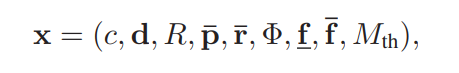

In [ ]:
gens = alldata["gens"]
sum_pmax = sum(gen_i.Pmax for gen_i in gens.values())
alpha_r = 5 * max_pmax * (sum_pmax**-1)
baseMVA = alldata["baseMVA"]
bus = alldata["buses"]
branch = alldata["branches"]

In [ ]:
c = [gens[g].costvector for g in gens.keys()]
# d = x_varied[0][0]
# R = x_varied[0][1]
p_bar = [gens[g].Pmax for g in gens.keys()]
r_bar = [alpha_r * gens[g].Pmax * gens[g].status for g in gens.keys()]
PI = makePTDF(baseMVA, bus, branch, slack=None) #PTDF
f_bar = [alldata["branches"][b].limit for b in alldata["branches"].keys()] # f_bar just change the sign
M_th = 1500

In [ ]:
# print(model.getVarByName('Gr_1_4').x,
#       model.getVarByName('Gr_1_4').UB,
#       model.getVarByName('Gr_1_4').LB
#       )
# for v in model.getVars():
#     if 'Gr_' in v.VarName:
#         print(v.X)